In [1]:
pip install pyspark


# Import necessary packages

In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import col, when
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import RandomForestClassificationModel, GBTClassificationModel


In [10]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("CustomerChurnPrediction") \
    .getOrCreate()

# 1. Loading the dataset
data_path = '/content/Churn_Modelling.csv'  # Replace with the actual path to your dataset
df = spark.read.csv(data_path, header=True, inferSchema=True)


In [12]:
# Show the schema and preview of the data
df.printSchema()
df.show(5)

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+----

+------+-----+
|Exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



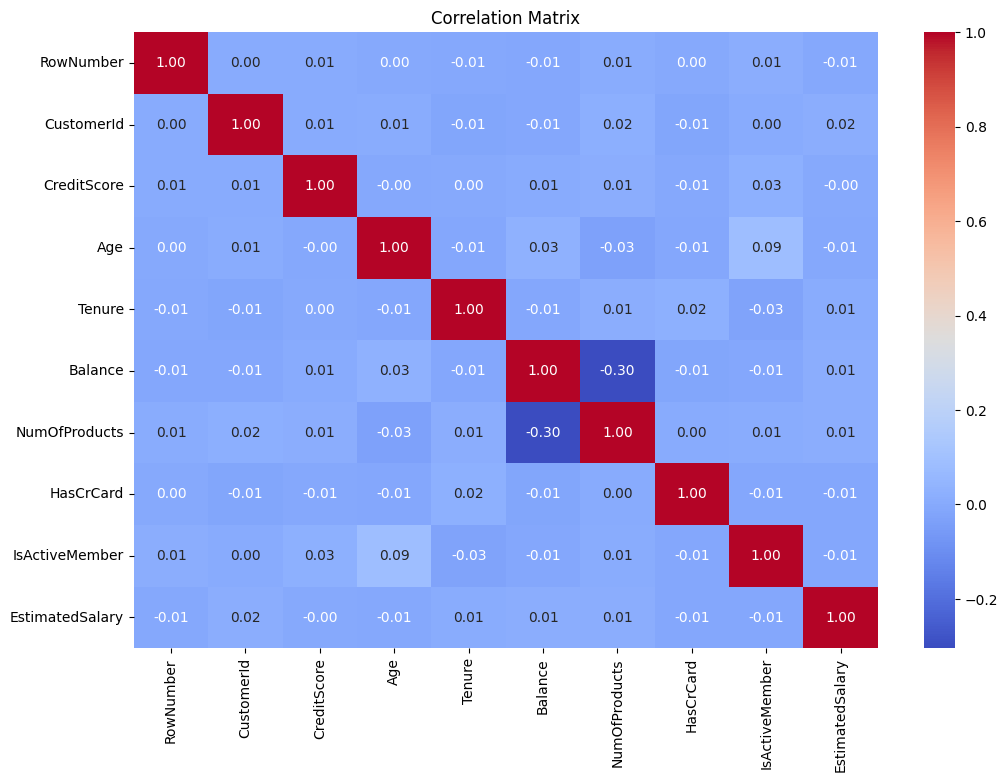

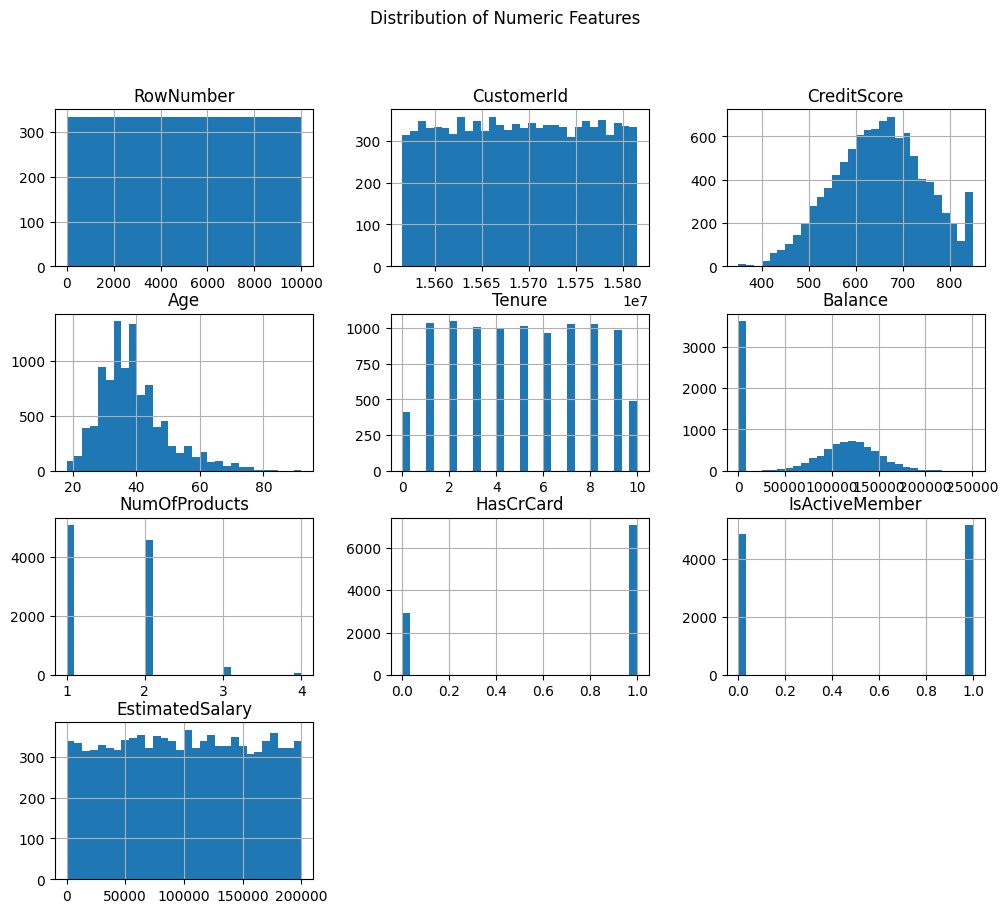

In [11]:
# 2. Exploratory Data Analysis (EDA)

# Distribution of the target variable 'Exited'
df.groupBy('Exited').count().show()

# Correlation matrix for numeric features (we'll use Pandas for easier manipulation)
numeric_cols = [col for col, dtype in df.dtypes if dtype in ['int', 'double'] and col != 'Exited']
numeric_df = df.select(numeric_cols)
numeric_pandas_df = numeric_df.toPandas()

# Compute correlation matrix
correlation_matrix = numeric_pandas_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Distribution of numeric features (histograms)
numeric_df.toPandas().hist(figsize=(12, 10), bins=30)
plt.suptitle('Distribution of Numeric Features')
plt.show()

In [13]:
# 3. Data Preprocessing
# Handle missing values by removing rows with missing target variable
df = df.dropna()

# Convert categorical variables into numeric using StringIndexer
categorical_cols = ['Geography', 'Gender']
indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + '_index') for col_name in categorical_cols]

# Encode the target variable (Exited) to binary (1 for churn, 0 for not churn)
df = df.withColumn('Exited', when(col('Exited') == 1, 1).otherwise(0))

# Create a feature vector
assembler = VectorAssembler(inputCols=numeric_cols + [col + '_index' for col in categorical_cols],
                            outputCol='features')

In [14]:
# Split the data into training and testing sets (80-20 split)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [15]:
# 4. Define Classification Models
log_reg = LogisticRegression(featuresCol='features', labelCol='Exited')
rf = RandomForestClassifier(featuresCol='features', labelCol='Exited')
gbt = GBTClassifier(featuresCol='features', labelCol='Exited')
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Exited')
svm = LinearSVC(featuresCol='features', labelCol='Exited')

models = [log_reg, rf, gbt, dt, svm]
model_names = ['Logistic Regression', 'Random Forest', 'GBT', 'Decision Tree', 'SVM']

In [18]:
# 5. Evaluate the model using various metrics
def evaluate_model(predictions):
    # Define evaluators
    binary_evaluator = BinaryClassificationEvaluator(labelCol="Exited", metricName="areaUnderROC")
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", metricName="accuracy")
    precision_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", metricName="weightedRecall")
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="Exited", metricName="f1")

    # Calculate metrics
    accuracy = accuracy_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1 = f1_evaluator.evaluate(predictions)
    roc_auc = binary_evaluator.evaluate(predictions)

    return accuracy, precision, recall, f1, roc_auc

# Store results
results = {}

for model, name in zip(models, model_names):
    pipeline = Pipeline(stages=indexers + [assembler, model])
    pipeline_model = pipeline.fit(train_df)
    predictions = pipeline_model.transform(test_df)

    # Evaluate the model using various metrics
    accuracy, precision, recall, f1, roc_auc = evaluate_model(predictions)
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

# Display results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("-" * 40)

Logistic Regression:
Accuracy: 0.8064
Precision: 0.7737
Recall: 0.8064
F1-Score: 0.7663
ROC-AUC: 0.7568
----------------------------------------
Random Forest:
Accuracy: 0.8470
Precision: 0.8457
Recall: 0.8470
F1-Score: 0.8179
ROC-AUC: 0.8365
----------------------------------------
GBT:
Accuracy: 0.8589
Precision: 0.8497
Recall: 0.8589
F1-Score: 0.8448
ROC-AUC: 0.8728
----------------------------------------
Decision Tree:
Accuracy: 0.8558
Precision: 0.8478
Recall: 0.8558
F1-Score: 0.8375
ROC-AUC: 0.5820
----------------------------------------
SVM:
Accuracy: 0.7949
Precision: 0.6319
Recall: 0.7949
F1-Score: 0.7041
ROC-AUC: 0.7492
----------------------------------------


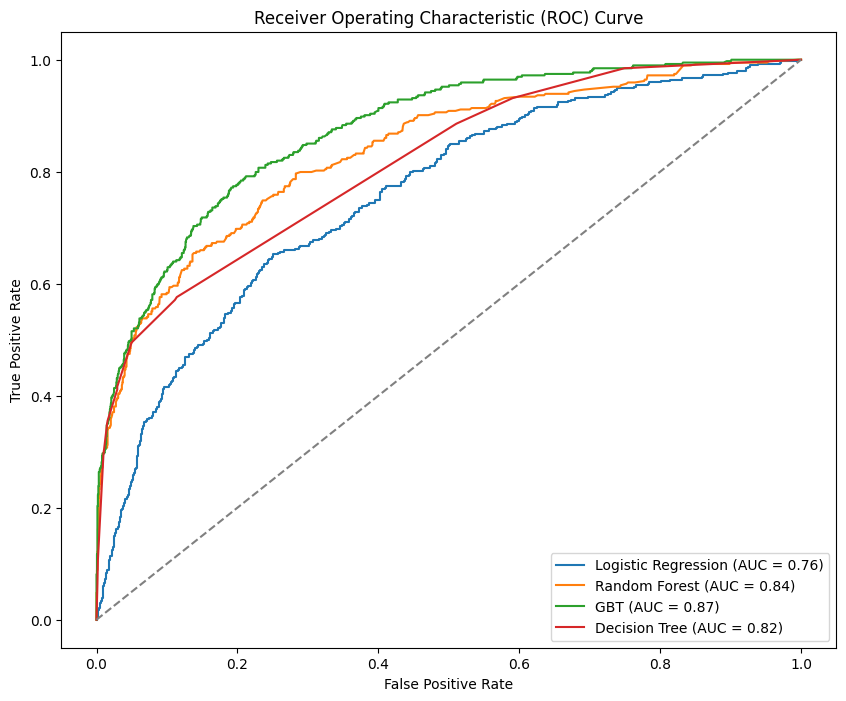

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Initialize dictionaries to store the fpr, tpr, and roc_auc for each model
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

# Generate ROC curve data for each model
for model, name in zip(models, model_names):
    pipeline = Pipeline(stages=indexers + [assembler, model])
    pipeline_model = pipeline.fit(train_df)
    predictions = pipeline_model.transform(test_df)

    # Check if the model provides a 'probability' column
    prob_col = 'probability'  # Default column name for probability
    if prob_col in predictions.columns:  # Only proceed if the model outputs probabilities
        # Get the probabilities for ROC curve (requires the probability column)
        probs = predictions.select("Exited", prob_col).rdd.map(lambda row: (row[0], row[1][1])).collect()
        true_labels, pred_probs = zip(*probs)

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        fpr_dict[name] = fpr
        tpr_dict[name] = tpr
        roc_auc_dict[name] = auc(fpr, tpr)

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Plot ROC curves for models with AUC
for model_name in model_names:
    if model_name in fpr_dict:  # Ensure the model has an ROC curve
        plt.plot(fpr_dict[model_name], tpr_dict[model_name], label=f'{model_name} (AUC = {roc_auc_dict[model_name]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()
